In [38]:
import numpy as np
import pandas as pd

from biclustlib.algorithms import *
from biclustlib.models import Bicluster, Biclustering
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import iterable
from typing import List
import logging

In [3]:
np.random.seed(42)

In [4]:
def enable_logging(enable: bool):
    logging_level = [logging.CRITICAL, logging.DEBUG][int(enable)]
    logging.getLogger(__name__).setLevel(logging_level)

In [5]:
### Set True if you want to use logging, False otherwise ###
logging.basicConfig(format='%(asctime)s: "%(message)s"', datefmt="%H:%M:%S")
enable_logging(False)

### NBCF

In [6]:
def sim(user_items: np.ndarray, bicluster: Bicluster):
    return len(np.intersect1d(user_items.nonzero(), bicluster.cols)) / len(bicluster.cols)

In [7]:
def wf(user_items: np.ndarray, bicluster: Bicluster):
    return sim(user_items, bicluster) * len(bicluster.rows)

In [8]:
def NBCF(user_items: np.ndarray, biclusters: Biclustering):
    results = [[wf(user_items, cluster), cluster] for cluster in biclusters.biclusters]
    results.sort(key=lambda x: -x[0])
    return results

## Recommendations

In [9]:
def recommendation(df: pd.DataFrame, user_items: np.ndarray, biclusters: Biclustering, k_items: int):
    if isinstance(user_items, pd.Series):
        user_items = np.array(user_items)

    items_to_recommend = set()
    neighboring_biclusters = NBCF(user_items, biclusters)
    for i, biclust_to_analyze in neighboring_biclusters:
        item_ratings = []

        users_ratings = df.iloc[biclust_to_analyze.rows, biclust_to_analyze.cols]
        item_ratings = list(zip(np.mean(users_ratings[users_ratings != 0], axis=0), biclust_to_analyze.cols))

        if len(item_ratings) != 0:
            item_ratings.sort(key=lambda x: -x[0])
            items_to_recommend |= {p[1] for p in item_ratings[: k_items]}

        if len(items_to_recommend) >= k_items:
            break

    return list(items_to_recommend)[:k_items]

In [10]:
def binary_recommendation(df: pd.DataFrame, user_items: np.ndarray, biclusters: Biclustering, k_items: int):
    if isinstance(user_items, pd.Series):
        user_items = np.array(user_items)

    items_to_recommend = set()
    neighboring_biclusters = NBCF(user_items, biclusters)
    for _, biclust_to_analyze in neighboring_biclusters:
        items_to_recommend |= set(biclust_to_analyze.cols[: k_items])
        if len(items_to_recommend) >= k_items:
            break

    return list(items_to_recommend)[:k_items]

## Metrics

In [11]:
def precision(prediction: np.ndarray, user_items: np.ndarray, positive_threshold: float) -> float:
    return len(np.intersect1d(np.nonzero(user_items > positive_threshold), prediction)) / len(prediction) if len(prediction) != 0 else 0

In [12]:
def recall(prediction: np.ndarray, user_items: np.ndarray, positive_threshold: float) -> float:
    liked_items = np.nonzero(user_items > positive_threshold)
    return len(np.intersect1d(liked_items, prediction)) / len(liked_items[0]) if len(liked_items[0]) != 0 else 0

In [13]:
def f1_score(precisions: iterable, recalls: list):
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    dividend = 2 * (precisions * recalls)
    divider = precisions + recalls
    return np.divide(dividend, divider, out=np.zeros_like(dividend), where = divider != 0)

In [14]:
def stability(values: list) -> float:
    """
    Calculates the difference between the minimum and maximum value in the list
    :param values: list of values. Precisions, for instance
    :return: number from 0 to 1. 1 = stable, 0 = unstable
    """
    return 1 - (np.max(values) - np.min(values))

In [15]:
def calc_metric(data: pd.DataFrame, sample: pd.DataFrame, biclustering: Biclustering, n_items: int, metric: callable,
                is_binary: bool = False, positive_threshold: float = 3) -> float:
    """
    Return precision or recall (depending on 'metric' parameter) for sample dataframe
    :param data: original df
    :param sample: test df
    :param biclustering: biclusters
    :param n_items: number of recommendations
    :param metric: precision or recall function
    :param is_binary: is data binary or not. Set to True for BiBit algorithm
    :param positive_threshold: threshold for items filtering
    :return: mean of precisions for each user
    """

    recommendation_function = [recommendation, binary_recommendation][is_binary]
    positive_threshold *= not is_binary

    metric_values = [
        metric(
            rec := recommendation_function(
                data,
                sample.iloc[i],
                biclustering,
                n_items
            ),
            np.asarray(sample.iloc[i]),
            positive_threshold
        ) for i in range(len(sample))]
    logging.getLogger(__name__).debug(f"Finish calculating {metric.__name__} for n_items = {n_items}")
    return float(np.mean(metric_values))

In [16]:
def getPrecisionsAndRecalls(
        df: pd.DataFrame, test: pd.DataFrame, y_train: Biclustering,
        positive_threshold: float = 3, make_binary: bool = False, items_count: iterable = np.arange(5, 55, 5)):
    """
    Return array of arrays of precisions and recalls
    :param df: original data
    :param test: test users
    :param y_train: biclustering, that we get from algorithm running
    :param positive_threshold: threshold for 'good items'. 3 by default
    :param make_binary: transform data to binary representation. False by default
    :param items_count: iterable of N-s for top-N recommendations
    :return: list of precisions and recalls
    """
    logging.getLogger(__name__).debug("Biclustering has been finished")
    df_ = df.copy()
    test_ = test.copy()

    if make_binary:
        df_[df_ <= positive_threshold] = 0
        df_[df_ > positive_threshold] = 1
        test_[test_ <= positive_threshold] = 0
        test_[test_ > positive_threshold] = 1

    return [calc_metric(df_, test_, y_train, c, precision, make_binary, positive_threshold) for c in items_count], [
        calc_metric(df_, test_, y_train, c, recall, make_binary, positive_threshold) for c in items_count]

## Datasets

In [17]:
def _ml_100k_preprocessing(ml_df: pd.DataFrame):
    return ml_df.fillna(0)


def _jester_100k_preprocessing(jester_df: pd.DataFrame):
    preproc_jester = jester_df.copy()
    preproc_jester += 11
    return preproc_jester.round().fillna(0).astype(int)


def load_dataset(name: str, preprocessing: bool = True): # TODO change directories (e.g. 'datasets/ml', 'datasets/jester-...'
    available_datasets = ["ml-100k", "jester"] # TODO kill this hardcode

    preprocessing_funcs = {
        "ml-100k" : _ml_100k_preprocessing,
        "jester" : _jester_100k_preprocessing
    }

    name = name.lower().strip()

    if name == "ml-100k":
        dataset_dir = "ml"

        r_cols = ['userId', 'movieId', 'rating', 'unix_timestamp']
        ratings = pd.read_csv(f'{dataset_dir}/u.data', sep='\t', names=r_cols, encoding='latin-1')

        m_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url']
        movies = pd.read_csv(f'{dataset_dir}/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

        # Drop useless features
        ratings = ratings.drop(["unix_timestamp"], axis=1)
        movies = movies.drop(["release_date", "video_release_date", "imdb_url"], axis=1)

        total = pd.merge(ratings, movies, on="movieId")

        # Complete dataset matrix
        _ml_100k_df = pd.pivot_table(data=total, index="userId", columns="title", values="rating")
        return preprocessing_funcs[name](_ml_100k_df) if preprocessing else _ml_100k_df
    elif name == "jester":
        original_jester_df = pd.read_excel("jester-data-1.xls", names=range(1, 101), header=None, na_values=99).reset_index(drop=True)
        return preprocessing_funcs[name](original_jester_df) if preprocessing else original_jester_df
    else:
        raise ValueError(f"Unknown dataset '{name}'. Available datasets: {', '.join(available_datasets)}")

In [18]:
def make_binary(df: pd.DataFrame, threshold: float):
    to_binarize = df.copy()
    to_binarize[to_binarize <= threshold] = 0
    to_binarize[to_binarize > threshold] = 1
    return to_binarize

In [19]:
def surprise_suiting(user_item_table: pd.DataFrame) -> pd.DataFrame:
    """Transform user/item matrix into surprise-library representation"""
    d = np.array(user_item_table)
    res = [(row, index, d[row, index]) for row in range(d.shape[0]) for index in range(d.shape[1]) if d[row, index] != 0]

    return pd.DataFrame(res, columns=["user_id", "item_id", "rating"])

In [20]:
ml_df = load_dataset("ml-100k")
ml_df

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
jester_df = load_dataset("jester")
jester_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,3,20,1,3,3,2,1,15,2,6,...,14,0,0,0,0,0,5,0,0,0
1,15,11,17,15,9,1,10,6,20,20,...,14,6,11,19,11,9,14,11,7,12
2,0,0,0,0,20,20,20,20,0,0,...,0,0,0,20,0,0,0,0,0,0
3,0,19,0,0,13,19,8,17,0,13,...,0,0,0,12,0,0,0,0,0,0
4,20,16,7,6,12,13,18,16,11,17,...,16,17,15,16,17,13,14,18,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,11,18,20,13,14,18,2,10,2,18,...,20,10,20,4,19,20,18,20,20,18
24979,20,3,20,20,12,2,8,17,3,16,...,10,5,10,11,20,3,4,2,20,19
24980,0,0,0,0,3,0,18,4,0,0,...,0,0,0,0,0,0,0,0,0,0
24981,0,0,0,0,1,0,16,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Without preprocessing
original_jester_df = load_dataset("jester", preprocessing=False)
original_jester_df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def normalize(df_to_normalize: pd.DataFrame):
    return df_to_normalize[df_to_normalize != 0].sub(df_to_normalize[df_to_normalize != 0].mean(axis=1), axis=0).fillna(0)

## Some dataset information

In [24]:
def density(df: pd.DataFrame):
    return (df > 0).values.sum() / (df.shape[0] * df.shape[1])


print(f"ML100k density = {round(density(ml_df), 3)}")
print(f"Jester density = {round(density(jester_df), 3)}")

ML100k density = 0.064
Jester density = 0.725


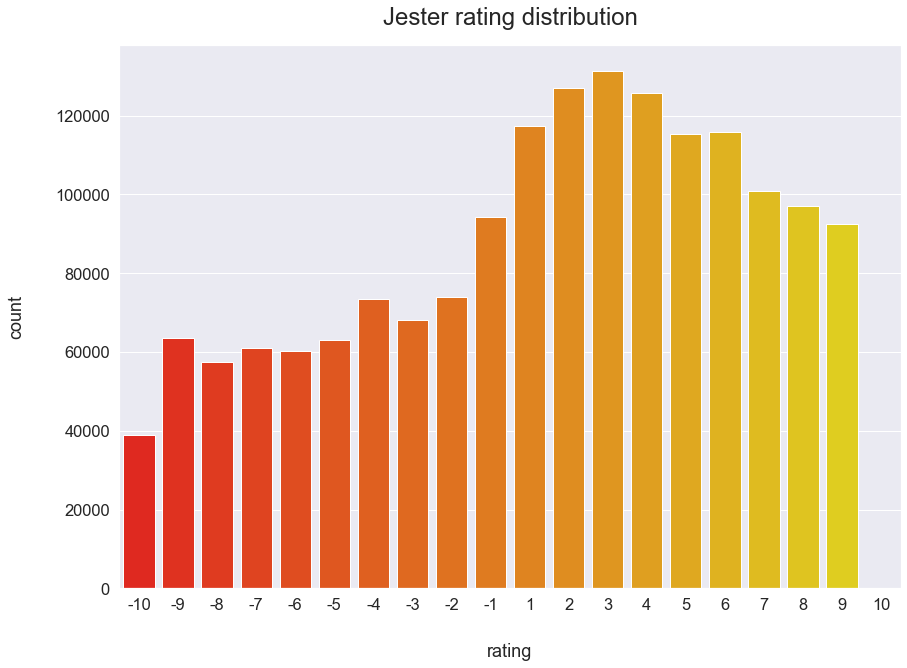

In [25]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelpad'] = 30
sns.set(font_scale=1.5)
plt.title("Jester rating distribution", pad=20, fontsize=24)

p = sns.countplot(x=surprise_suiting(original_jester_df.round().fillna(0)).rating.astype(int), palette="autumn")

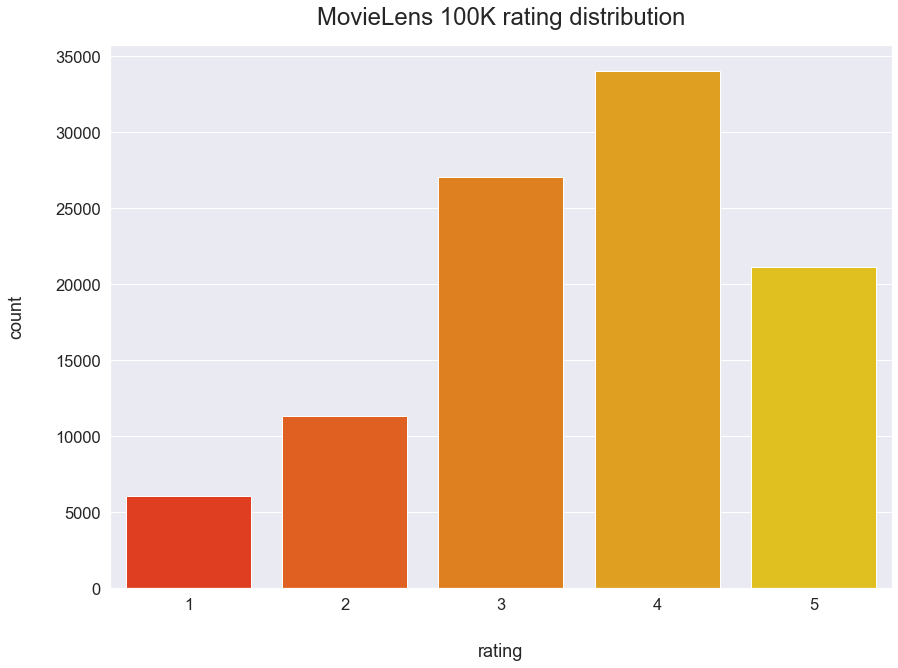

In [26]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelpad'] = 30
sns.set(font_scale=1.5)
plt.title("MovieLens 100K rating distribution", pad=20, fontsize=24)

_ = sns.countplot(x=surprise_suiting(ml_df).rating.astype(int), palette="autumn")

## Biclusters functions

In [27]:
def biclusters_quality(biclusters: Biclustering):
    """
    Calculates the quality of the biclusters: the percentage of biclusters overlapping
    :param biclusters: biclustering object
    :return: number from 0 to 1. Zero indicates perfect biclusters, while one indicates a full overlapping
    """
    similarity = [cluster.overlap(another) for i, cluster in enumerate(biclusters.biclusters) for another in biclusters.biclusters[i + 1:]]
    return np.mean(similarity) if similarity else 0

In [28]:
def find_best_biclusters(user: pd.Series, sort_by: str = "WF"):
    """
    Return information about the best biclusters for current user: bicluster number - number of appropriate items - weighed frequency
    :param user: user to analyse
    :param sort_by: name of the column relative to which we sort dataframe
    :return: dataframe
    """
    info = []
    for i, bicluster in enumerate(ml_y_train_spectral.biclusters):
        info.append((i, user[bicluster.cols].sum(), wf(np.array(user), bicluster)))

    info.sort(key=lambda x: -x[1])
    d = pd.DataFrame(info, columns=["Bicluster №", "Good Items", "WF"])
    d["WF"] = round(d["WF"], 2)
    d["Good Items"] = d["Good Items"].astype(int)
    return d.sort_values(sort_by, ascending=False)

In [29]:
def bicluster_average(sample: pd.DataFrame, bicl: Bicluster):
    """Calculate average value in bicluster, excluding missing values"""
    t = sample.iloc[bicl.rows, bicl.cols]
    if (t > 0).sum().sum() < 1e-6:
        return 0
    return t[t > 0].sum().sum() / (t > 0).sum().sum()

In [30]:
def biclustering_statictics(precisions_lst: list, recalls_lst: list, algo_names: List[str]):
    stabilities = [np.round(stability(precisions), 2) for precisions in precisions_lst]
    precision_means = [np.round(np.mean(precisions), 2) for precisions in precisions_lst]
    recalls_means = [np.round(np.mean(recalls), 2) for recalls in recalls_lst]
    f1_score_means = [np.round(np.mean(f1_score(precisions, recalls)), 2) for precisions, recalls in zip(precisions_lst, recalls_lst)]

    return pd.DataFrame([stabilities, precision_means, recalls_means, f1_score_means], columns=algo_names, index=["Stability", "Average precision", "Average recall", "Average F1 score"])

In [31]:
def user_coverage(df_train: pd.DataFrame, biclustering: Biclustering):
    rows = set()
    for bicluster in biclustering.biclusters:
        rows.update(bicluster.rows)
    return len(rows) / len(df_train)


def item_coverage(df_train: pd.DataFrame, biclustering: Biclustering):
    rows = set()
    for bicluster in biclustering.biclusters:
        rows.update(bicluster.cols)
    return len(rows) / df_train.shape[1]


def coveragies(df_train: pd.DataFrame, y_trains: list, algo_names: list):
    uc_all = [round(user_coverage(df_train, y_train_cur) * 100, 1) for y_train_cur in y_trains]
    ic_all = [round(item_coverage(df_train, y_train_cur) * 100, 1) for y_train_cur in y_trains]
    return pd.DataFrame(data=[uc_all, ic_all, (np.array(uc_all) + np.array(ic_all)) / 2],
                        columns=algo_names, index=["User Coverage (%)", "Item Coverage (%)", "Mean Coverage (%)"])

## Naive KNN Biclustering

In [32]:
class NaiveKNNBiclustering:
    def __init__(self, positive_threshold: float, user_n_clusters: int = 5, item_n_clusters: int = 5):
        self.threshold = positive_threshold
        self.user_n_clusters = user_n_clusters
        self.item_n_clusters = item_n_clusters


    def run(self, train: pd.DataFrame):
        from sklearn.cluster import KMeans # KNN clustering

        # Users clustering
        model_users = KMeans(self.user_n_clusters)
        model_users.fit(train)
        labels_users = pd.Series(model_users.labels_)

        # Items clustering
        model_items = KMeans(self.user_n_clusters)
        model_items.fit(train.T)
        labels_items = pd.Series(model_items.labels_)

        # Transform into list of rows and then create Biclustering
        rows_clusters = [list(labels_users[labels_users == i].index) for i in range(self.user_n_clusters)]
        cols_clusters = [list(labels_items[labels_items == i].index) for i in range(self.user_n_clusters)]

        y_train_test_knn = Biclustering([Bicluster(r, c) for r in rows_clusters for c in cols_clusters])
        len(y_train_test_knn.biclusters)

        # Remove 'bad' biclusters with average value less than positive threshold
        return Biclustering([c for c in y_train_test_knn.biclusters if bicluster_average(train, c) > self.threshold])

# Graphs

In [33]:
# Array of recommendations numbers
items_count = np.arange(5, 55, 5)


def plot_metric_N_recom(metric_name: str, dataset_name: str, metric_values: List[list], algo_names: List[str], legend_loc: str = "upper right"):
    # Matplotlib settings
    plt.rcParams['figure.figsize'] = (15, 11)
    plt.rcParams['axes.labelpad'] = 30
    sns.set(font_scale=1.5)
    plt.ylim(0, 1)
    sns.set_theme(style="white")
    plt.xlabel("N recommendations")
    plt.ylabel(metric_name)
    plt.title(dataset_name, pad=20, fontsize=24)

    # Plotting
    prec = pd.DataFrame(metric_values, index=algo_names, columns=items_count)
    _ = sns.lineplot(data=prec.T, linewidth=4, dashes=False)
    l = plt.legend(fontsize=14, loc=legend_loc)
    for handler in l.legendHandles:
        handler.set_linewidth(5)

## Movielens

In [34]:
# Split by train and test
ml_train = ml_df.iloc[:700]
ml_test = ml_df.iloc[700:]

In [35]:
%%time
# Plaid
ml_precisions_plaid, ml_recalls_plaid = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_plaid := Plaid(30, True, 0.05, 0.05).run(ml_train), positive_threshold=3)

c:\Users\Razmik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Razmik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Razmik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Razmik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

CPU times: total: 3min 52s
Wall time: 1min 11s


In [36]:
%%time
# LargeAverageSubmatrices
ml_precisions_las, ml_recalls_las = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_las := LargeAverageSubmatrices(30, 0.8, 100).run(ml_train))

CPU times: total: 3min 20s
Wall time: 3min 22s


In [39]:
%%time
# Cheng
ml_precisions_cheng, ml_recalls_cheng = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_cheng := ChengChurchAlgorithm(30, data_min_cols=20).run(ml_train))

ValueError: data_min_cols must be >= 100, got 20

In [133]:
%%time
# BitPatternBiclusteringAlgorithm 365 biclusters
ml_precisions_bibit, ml_recalls_bibit = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_bibit := BitPatternBiclusteringAlgorithm(10, 10).run(make_binary(ml_train, 3)), positive_threshold=3, make_binary=True)

18:43:46: "Biclustering has been finished"
18:43:48: "Finish calculating precision for n_items = 5"
18:43:51: "Finish calculating precision for n_items = 10"
18:43:53: "Finish calculating precision for n_items = 15"
18:43:56: "Finish calculating precision for n_items = 20"
18:43:58: "Finish calculating precision for n_items = 25"
18:44:01: "Finish calculating precision for n_items = 30"
18:44:03: "Finish calculating precision for n_items = 35"
18:44:05: "Finish calculating precision for n_items = 40"
18:44:08: "Finish calculating precision for n_items = 45"
18:44:10: "Finish calculating precision for n_items = 50"
18:44:13: "Finish calculating recall for n_items = 5"
18:44:15: "Finish calculating recall for n_items = 10"
18:44:18: "Finish calculating recall for n_items = 15"
18:44:20: "Finish calculating recall for n_items = 20"
18:44:23: "Finish calculating recall for n_items = 25"
18:44:25: "Finish calculating recall for n_items = 30"
18:44:28: "Finish calculating recall for n_items 

CPU times: total: 4min 10s
Wall time: 4min 10s


In [134]:
len(ml_y_train_bibit.biclusters)

365

In [82]:
%%time
# TODO !!! Увеличение колва бикластеров == стабильность
# SpectralCoclustering
from sklearn.cluster import SpectralCoclustering

model_users = SpectralCoclustering(n_clusters=30, random_state=0)
ml_spectral_train = ml_train.copy()
ml_spectral_train += 1
clustering = model_users.fit(ml_spectral_train)

biclusters = [Bicluster(index[0], index[1]) for index in
              [clustering.get_indices(i) for i in range(clustering.n_clusters)]]
ml_y_train_spectral = Biclustering(biclusters)

# Delete empty biclusters
ml_y_train_spectral.biclusters = [c for c in ml_y_train_spectral.biclusters if len(c.rows) != 0 and len(c.cols) != 0]

ml_precisions_spectral, ml_recalls_spectral = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_spectral)

23:00:22: "Biclustering has been finished"
23:00:23: "Finish calculating precision for n_items = 5"
23:00:24: "Finish calculating precision for n_items = 10"
23:00:24: "Finish calculating precision for n_items = 15"
23:00:25: "Finish calculating precision for n_items = 20"
23:00:26: "Finish calculating precision for n_items = 25"
23:00:27: "Finish calculating precision for n_items = 30"
23:00:27: "Finish calculating precision for n_items = 35"
23:00:28: "Finish calculating precision for n_items = 40"
23:00:29: "Finish calculating precision for n_items = 45"
23:00:30: "Finish calculating precision for n_items = 50"
23:00:31: "Finish calculating recall for n_items = 5"
23:00:31: "Finish calculating recall for n_items = 10"
23:00:32: "Finish calculating recall for n_items = 15"
23:00:33: "Finish calculating recall for n_items = 20"
23:00:34: "Finish calculating recall for n_items = 25"
23:00:35: "Finish calculating recall for n_items = 30"
23:00:35: "Finish calculating recall for n_items 

CPU times: total: 21.5 s
Wall time: 17.1 s


In [136]:
%%time
# RANDOM
ml_precisions_random, ml_recalls_random = [], []
for c in items_count:
    ml_precisions_random.append(np.array([precision(np.random.choice(range(ml_test.shape[1]), c), np.array(ml_test.iloc[i]), 3) for i in range(len(ml_test))]).mean())
    ml_recalls_random.append(np.array([recall(np.random.choice(range(ml_test.shape[1]), c), np.array(ml_test.iloc[i]), 3) for i in range(len(ml_test))]).mean())

CPU times: total: 1.27 s
Wall time: 1.27 s


In [264]:
%%time
# Naive KNN Biclustering
ml_precisions_naive_knn, ml_recalls_naive_knn = getPrecisionsAndRecalls(ml_df, ml_test, ml_y_train_naive_knn := NaiveKNNBiclustering(3.5, 30, 30).run(ml_train), positive_threshold=3, items_count=items_count)

21:23:51: "Biclustering has been finished"
21:23:58: "Finish calculating precision for n_items = 5"
21:24:08: "Finish calculating precision for n_items = 10"
21:24:19: "Finish calculating precision for n_items = 15"
21:24:32: "Finish calculating precision for n_items = 20"
21:24:45: "Finish calculating precision for n_items = 25"
21:24:59: "Finish calculating precision for n_items = 30"
21:25:13: "Finish calculating precision for n_items = 35"
21:25:30: "Finish calculating precision for n_items = 40"
21:25:46: "Finish calculating precision for n_items = 45"
21:26:03: "Finish calculating precision for n_items = 50"
21:26:11: "Finish calculating recall for n_items = 5"
21:26:20: "Finish calculating recall for n_items = 10"
21:26:30: "Finish calculating recall for n_items = 15"
21:26:43: "Finish calculating recall for n_items = 20"
21:26:56: "Finish calculating recall for n_items = 25"
21:27:10: "Finish calculating recall for n_items = 30"
21:27:24: "Finish calculating recall for n_items 

CPU times: total: 4min 33s
Wall time: 4min 23s


In [265]:
biclustering_statictics([ml_precisions_naive_knn], [ml_recalls_naive_knn], ["Naive KNN Biclustering"])

,Naive KNN Biclustering
Stability,0.72
Average precision,0.43
Average recall,0.28
Average F1 score,0.31


In [266]:
coveragies(ml_train, [ml_y_train_naive_knn], ["Naive KNN Biclustering"])

,Naive KNN Biclustering
User Coverage (%),100.0
Item Coverage (%),100.0
Mean Coverage (%),100.0


In [267]:
pd.DataFrame([round(biclusters_quality(bicl) * 100, 1) for bicl in [ml_y_train_naive_knn]], index=["Naive KNN Biclustering"], columns=["Biclusters Overlapping"])

,Biclusters Overlapping
Naive KNN Biclustering,0.0


In [183]:
# COCLUST 20 and 20 biclusters
ml_precisions_coclust = [0.649, 0.639, 0.635, 0.633, 0.632, 0.631, 0.631, 0.63, 0.63, 0.629]
ml_recalls_coclust = [0.252, 0.326, 0.356, 0.372, 0.382, 0.388, 0.392, 0.395, 0.397, 0.399]

# UBKNN
ml_precisions_ubknn = [0.703, 0.692, 0.687, 0.683, 0.681, 0.68, 0.68, 0.679, 0.679, 0.679]
ml_recalls_ubknn = [0.251, 0.308, 0.332, 0.344, 0.35, 0.355, 0.357, 0.359, 0.36, 0.36]

# SVD
ml_precisions_svd = [0.66, 0.653, 0.65, 0.65, 0.649, 0.648, 0.648, 0.648, 0.648, 0.648]
ml_recalls_svd = [0.233, 0.286, 0.304, 0.314, 0.32, 0.323, 0.326, 0.328, 0.329, 0.33]

In [286]:
ml_all_precisions = [
    ml_precisions_plaid,
    ml_precisions_las,
    ml_precisions_cheng,
    ml_precisions_bibit,
    ml_precisions_spectral,
    # ml_precisions_coclust,
    ml_precisions_ubknn,
    ml_precisions_svd,
    ml_precisions_random,
    # ml_precisions_naive_knn
]

ml_all_recalls = [
    ml_recalls_plaid,
    ml_recalls_las,
    ml_recalls_cheng,
    ml_recalls_bibit,
    ml_recalls_spectral,
    # ml_recalls_coclust,
    ml_recalls_ubknn,
    ml_recalls_svd,
    ml_recalls_random,
    # ml_recalls_naive_knn
]

ml_all_algo_names = [
    "Plaid",
    "LAS",
    "Cheng & Church",
    "BiBit",
    "Spectral Coclustering",
    # "COCLUST",
    "UBKNN",
    "SVD",
    "Random",
    # "Naive KNN Biclustering"
]

### Movielens precision

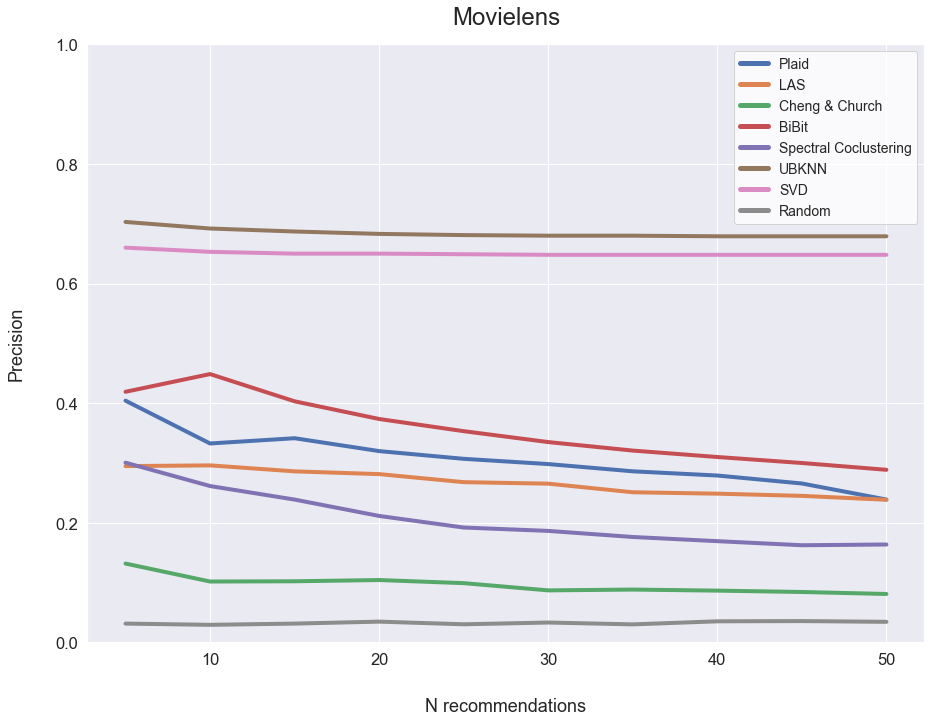

In [287]:
# PRECISION
plot_metric_N_recom("Precision", "Movielens", ml_all_precisions, ml_all_algo_names)

### Movielens recall

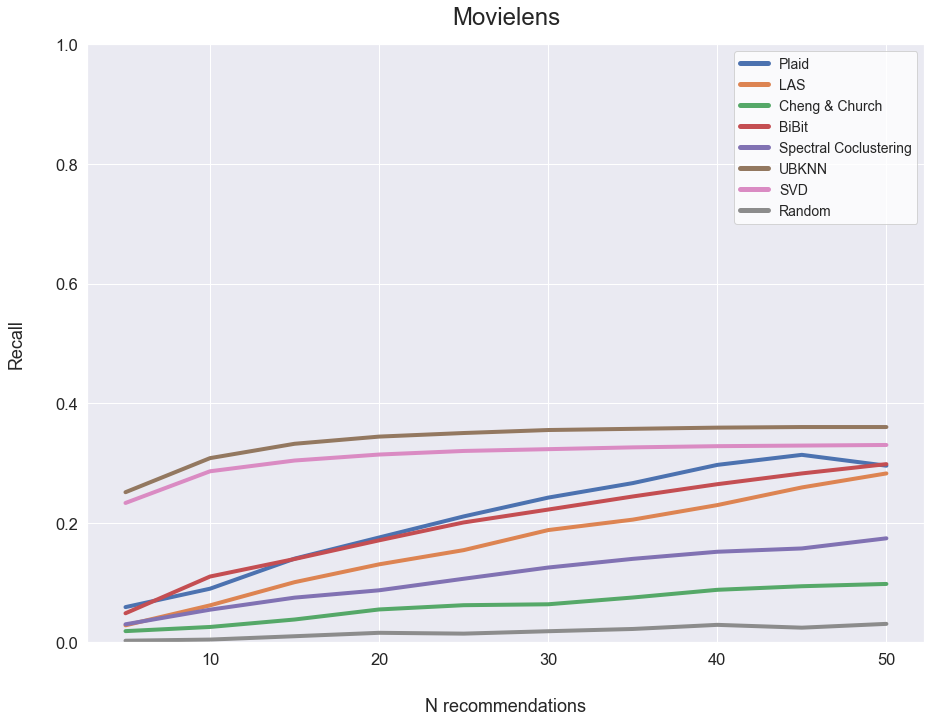

In [288]:
# RECALL
plot_metric_N_recom("Recall", "Movielens", ml_all_recalls, ml_all_algo_names)

### Movielens f1 score

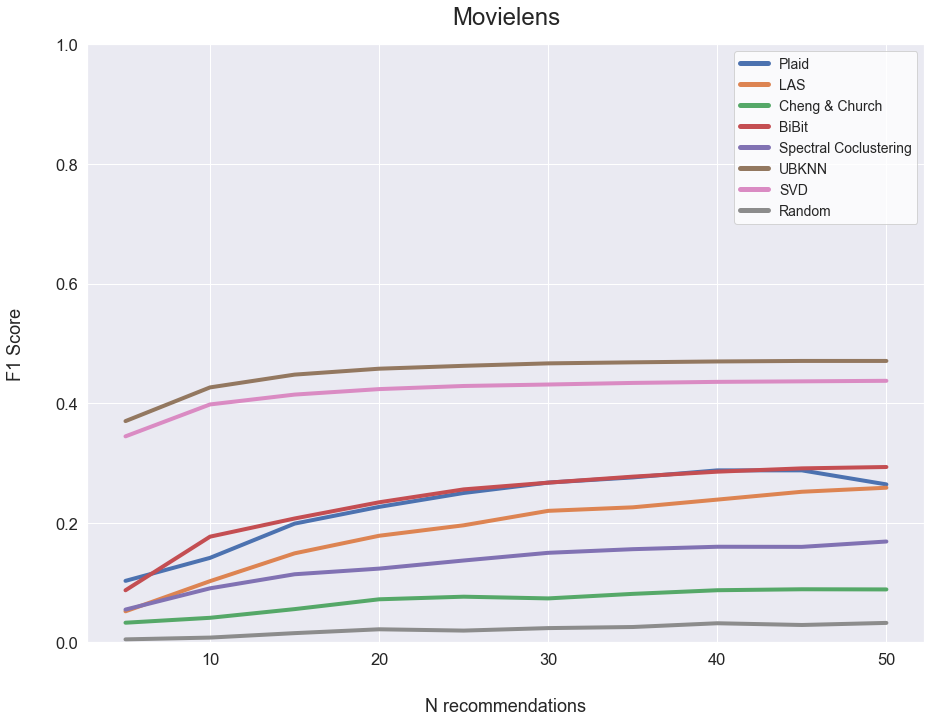

In [289]:
# F1 SCORE
plot_metric_N_recom("F1 Score", "Movielens", f1_score(ml_all_precisions, ml_all_recalls), ml_all_algo_names)

### Movielens metrics summary

In [233]:
# Statistics
precisions_lst = [ml_precisions_plaid, ml_precisions_cheng, ml_precisions_las, ml_precisions_bibit, ml_precisions_spectral, ml_precisions_ubknn, ml_precisions_svd, ml_precisions_random]
recalls_lst = [ml_recalls_plaid, ml_recalls_cheng, ml_recalls_las, ml_recalls_bibit, ml_recalls_spectral, ml_recalls_ubknn, ml_recalls_svd, ml_recalls_random]
names = ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral Coclustering", "UBKNN", "SVD", "Random"]

biclustering_statictics(ml_all_precisions, ml_all_recalls, ml_all_algo_names)

,Plaid,LAS,Cheng & Church,BiBit,Spectral Coclustering,UBKNN,SVD,Random
Stability,0.83,0.94,0.95,0.84,0.86,0.98,0.99,0.99
Average precision,0.31,0.27,0.10,0.36,0.21,0.68,0.65,0.03
Average recall,0.21,0.16,0.06,0.20,0.11,0.34,0.31,0.02
Average F1 score,0.23,0.19,0.07,0.24,0.13,0.45,0.42,0.02


--------

## Jester

In [145]:
# Train and test
jester_train = jester_df.iloc[:3000]
jester_test = jester_df.iloc[3000:4000]
items_count = np.arange(5, 55, 5)

In [294]:
%%time
# Plaid
jester_precisions_plaid, jester_recalls_plaid = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_plaid := Plaid(30, True, 0.03, 0.03).run(jester_train), positive_threshold=10, items_count=items_count)

01:15:46: "Biclustering has been finished"


KeyboardInterrupt: 

In [295]:
%%time
# Cheng
jester_precisions_cheng, jester_recalls_cheng = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_cheng := ChengChurchAlgorithm(50, data_min_cols=20).run(jester_train), positive_threshold=10, items_count=items_count)

01:15:55: "Biclustering has been finished"

KeyboardInterrupt



In [148]:
%%time
# LargeAverageSubmatrices
jester_precisions_las, jester_recalls_las = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_las := LargeAverageSubmatrices(30, 0.8, 100).run(jester_train), positive_threshold=10, items_count=items_count)

18:54:41: "Biclustering has been finished"
18:54:47: "Finish calculating precision for n_items = 5"
18:54:54: "Finish calculating precision for n_items = 10"
18:55:01: "Finish calculating precision for n_items = 15"
18:55:08: "Finish calculating precision for n_items = 20"
18:55:15: "Finish calculating precision for n_items = 25"
18:55:24: "Finish calculating precision for n_items = 30"
18:55:33: "Finish calculating precision for n_items = 35"
18:55:42: "Finish calculating precision for n_items = 40"
18:55:52: "Finish calculating precision for n_items = 45"
18:56:01: "Finish calculating precision for n_items = 50"
18:56:08: "Finish calculating recall for n_items = 5"
18:56:14: "Finish calculating recall for n_items = 10"
18:56:21: "Finish calculating recall for n_items = 15"
18:56:28: "Finish calculating recall for n_items = 20"
18:56:35: "Finish calculating recall for n_items = 25"
18:56:44: "Finish calculating recall for n_items = 30"
18:56:53: "Finish calculating recall for n_items 

CPU times: total: 2min 43s
Wall time: 2min 43s


In [271]:
%%time
# BitPatternBiclusteringAlgorithm: 136 biclusters for arguments (30, 20)
jester_precisions_bibit, jester_recalls_bibit = getPrecisionsAndRecalls(jester_df, jester_test[:150], jester_y_train_bibit := BitPatternBiclusteringAlgorithm(30, 20).run(make_binary(jester_train[:400], 10)), positive_threshold=10, make_binary=True, items_count=items_count)

22:19:45: "Biclustering has been finished"
22:19:46: "Finish calculating precision for n_items = 5"
22:19:46: "Finish calculating precision for n_items = 10"
22:19:47: "Finish calculating precision for n_items = 15"
22:19:47: "Finish calculating precision for n_items = 20"
22:19:48: "Finish calculating precision for n_items = 25"
22:19:48: "Finish calculating precision for n_items = 30"
22:19:49: "Finish calculating precision for n_items = 35"
22:19:49: "Finish calculating precision for n_items = 40"
22:19:49: "Finish calculating precision for n_items = 45"
22:19:50: "Finish calculating precision for n_items = 50"
22:19:50: "Finish calculating recall for n_items = 5"
22:19:51: "Finish calculating recall for n_items = 10"
22:19:51: "Finish calculating recall for n_items = 15"
22:19:52: "Finish calculating recall for n_items = 20"
22:19:52: "Finish calculating recall for n_items = 25"
22:19:53: "Finish calculating recall for n_items = 30"
22:19:53: "Finish calculating recall for n_items 

CPU times: total: 1min 32s
Wall time: 1min 32s


In [272]:
len(jester_y_train_bibit.biclusters)

136

In [151]:
%%time
# SpectralCoclustering
model_users = SpectralCoclustering(n_clusters=30, random_state=0)
jester_spectral = jester_train.copy()
jester_spectral += 1
clustering = model_users.fit(jester_spectral)
biclusters = [Bicluster(index[0], index[1]) for index in [clustering.get_indices(i) for i in range(clustering.n_clusters)]]
jester_y_train_spectral = Biclustering(biclusters)

# Delete empty biclusters
jester_y_train_spectral.biclusters = [c for c in jester_y_train_spectral.biclusters if len(c.rows) != 0 and len(c.cols) != 0]

jester_precisions_spectral, jester_recalls_spectral = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_spectral, positive_threshold=10, items_count=items_count)

18:58:55: "Biclustering has been finished"
18:58:59: "Finish calculating precision for n_items = 5"
18:59:05: "Finish calculating precision for n_items = 10"
18:59:12: "Finish calculating precision for n_items = 15"
18:59:20: "Finish calculating precision for n_items = 20"
18:59:29: "Finish calculating precision for n_items = 25"
18:59:40: "Finish calculating precision for n_items = 30"
18:59:53: "Finish calculating precision for n_items = 35"
19:00:08: "Finish calculating precision for n_items = 40"
19:00:24: "Finish calculating precision for n_items = 45"
19:00:41: "Finish calculating precision for n_items = 50"
19:00:45: "Finish calculating recall for n_items = 5"
19:00:51: "Finish calculating recall for n_items = 10"
19:00:58: "Finish calculating recall for n_items = 15"
19:01:06: "Finish calculating recall for n_items = 20"
19:01:15: "Finish calculating recall for n_items = 25"
19:01:26: "Finish calculating recall for n_items = 30"
19:01:39: "Finish calculating recall for n_items 

CPU times: total: 3min 37s
Wall time: 3min 32s


In [241]:
%%time
# Naive KNN Biclustering
jester_precisions_naive_knn, jester_recalls_naive_knn = getPrecisionsAndRecalls(jester_df, jester_test, jester_y_train_naive_knn := NaiveKNNBiclustering(10, 30, 30).run(jester_train), positive_threshold=10, items_count=items_count)

20:38:52: "Biclustering has been finished"
20:39:07: "Finish calculating precision for n_items = 5"
20:39:24: "Finish calculating precision for n_items = 10"
20:39:43: "Finish calculating precision for n_items = 15"
20:40:04: "Finish calculating precision for n_items = 20"
20:40:25: "Finish calculating precision for n_items = 25"
20:40:50: "Finish calculating precision for n_items = 30"
20:41:21: "Finish calculating precision for n_items = 35"
20:42:10: "Finish calculating precision for n_items = 40"
20:43:23: "Finish calculating precision for n_items = 45"
20:45:00: "Finish calculating precision for n_items = 50"
20:45:15: "Finish calculating recall for n_items = 5"
20:45:32: "Finish calculating recall for n_items = 10"
20:45:51: "Finish calculating recall for n_items = 15"
20:46:11: "Finish calculating recall for n_items = 20"
20:46:33: "Finish calculating recall for n_items = 25"
20:46:58: "Finish calculating recall for n_items = 30"
20:47:30: "Finish calculating recall for n_items 

CPU times: total: 12min 26s
Wall time: 12min 21s


In [219]:
# Data from surprise
# Coclust
jester_precisions_coclust = [0.521, 0.53, 0.531, 0.524, 0.539, 0.56, 0.573, 0.579, 0.578, 0.588]
jester_recalls_coclust = [0.065, 0.131, 0.199, 0.267, 0.344, 0.431, 0.516, 0.592, 0.65, 0.715]

# SVD
jester_precisions_svd = [0.798, 0.783, 0.771, 0.753, 0.737, 0.721, 0.709, 0.698, 0.688, 0.68]
jester_recalls_svd = [0.106, 0.208, 0.305, 0.392, 0.476, 0.551, 0.614, 0.667, 0.712, 0.75]

# UBKNN
jester_precisions_ubknn = [0.53, 0.536, 0.539, 0.533, 0.548, 0.569, 0.582, 0.588, 0.588, 0.598]
jester_recalls_ubknn = [0.065, 0.132, 0.2, 0.269, 0.346, 0.433, 0.518, 0.593, 0.652, 0.717]

In [153]:
%%time
# RANDOM
jester_precisions_random, jester_recalls_random = [], []
for c in items_count:
    jester_precisions_random.append(np.array([precision(np.random.choice(range(jester_test.shape[1]), c), np.array(jester_test.iloc[i]), 3) for i in range(len(jester_test))]).mean())
    jester_recalls_random.append(np.array([recall(np.random.choice(range(jester_test.shape[1]), c), np.array(jester_test.iloc[i]), 3) for i in range(len(jester_test))]).mean())

CPU times: total: 2.95 s
Wall time: 2.98 s


In [282]:
# TODO coclust
jester_all_precisions = [
    jester_precisions_plaid,
    jester_precisions_las,
    jester_precisions_cheng,
    jester_precisions_bibit,
    jester_precisions_spectral,
    # jester_precisions_coclust,
    jester_precisions_ubknn,
    jester_precisions_svd,
    jester_precisions_random,
    # jester_precisions_naive_knn
]

jester_all_recalls = [
    jester_recalls_plaid,
    jester_recalls_las,
    jester_recalls_cheng,
    jester_recalls_bibit,
    jester_recalls_spectral,
    # jester_recalls_coclust,
    jester_recalls_ubknn,
    jester_recalls_svd,
    jester_recalls_random,
    # jester_recalls_naive_knn
]

jester_all_algo_names = [
    "Plaid",
    "LAS",
    "Cheng & Church",
    "BiBit",
    "Spectral Coclustering",
    # "COCLUST",
    "UBKNN",
    "SVD",
    "Random",
    # "Naive KNN Biclustering"
]

### Jester precision

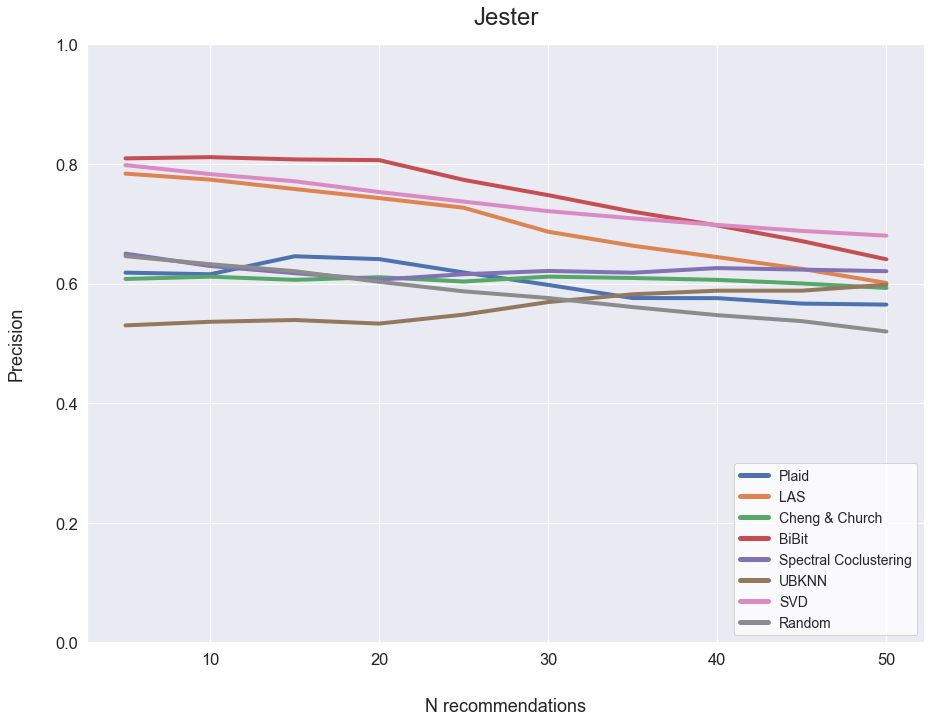

In [292]:
plot_metric_N_recom("Precision", "Jester", jester_all_precisions, jester_all_algo_names, legend_loc="lower right")

### Jester recall

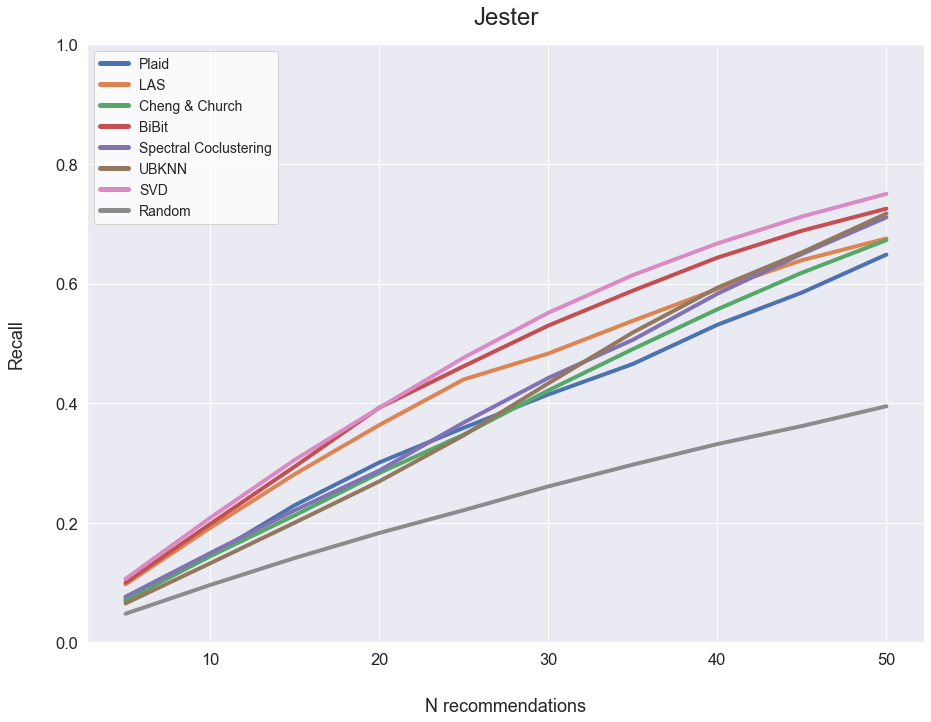

In [284]:
plot_metric_N_recom("Recall", "Jester", jester_all_recalls, jester_all_algo_names, legend_loc="upper left")

### Jester f1 score

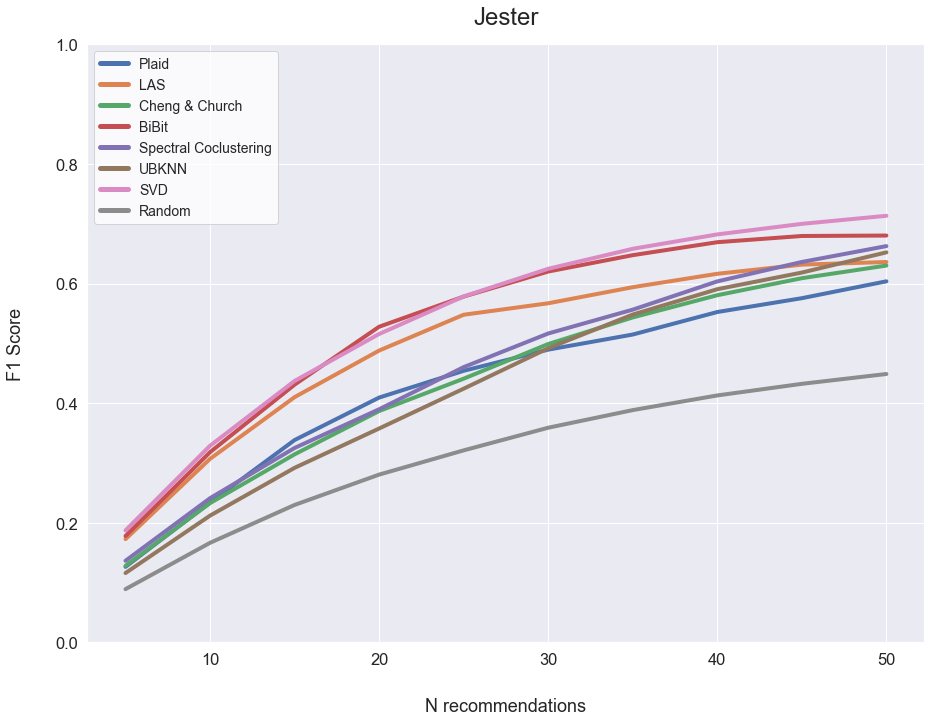

In [285]:
plot_metric_N_recom("F1 Score", "Jester", f1_score(jester_all_precisions, jester_all_recalls), jester_all_algo_names, legend_loc="upper left")

### Jester metrics summary

In [238]:
# Statistics
biclustering_statictics(jester_all_precisions, jester_all_recalls, jester_all_algo_names)

,Plaid,LAS,Cheng & Church,BiBit,Spectral Coclustering,UBKNN,SVD,Random
Stability,0.91,0.82,0.98,0.84,0.96,0.93,0.88,0.87
Average precision,0.57,0.70,0.61,0.75,0.62,0.56,0.73,0.58
Average recall,0.36,0.43,0.38,0.46,0.40,0.39,0.48,0.23
Average F1 score,0.41,0.50,0.44,0.53,0.45,0.43,0.54,0.31


In [159]:
# User/item coveragies
cs = coveragies(jester_train, [jester_y_train_plaid, jester_y_train_cheng, jester_y_train_las, jester_y_train_bibit, jester_y_train_spectral], ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral Coclust"])
cs["BiBit"] = coveragies(jester_train[:400], [jester_y_train_bibit], ["Bibit"])
cs

,Plaid,Cheng & Church,LAS,BiBit,Spectral Coclust
User Coverage (%),100.0,99.90,50.70,45.50,82.50
Item Coverage (%),100.0,85.00,100.00,55.00,100.00
Mean Coverage (%),100.0,92.45,75.35,50.25,91.25


In [160]:
# Biclusters overlapping
pd.DataFrame([round(biclusters_quality(bicl) * 100, 1) for bicl in [jester_y_train_plaid, jester_y_train_cheng, jester_y_train_las, jester_y_train_bibit, jester_y_train_spectral]], index= ["Plaid", "Cheng & Church", "LAS", "BiBit", "Spectral"], columns=["Biclusters Overlapping"])

,Biclusters Overlapping
Plaid,3.5
Cheng & Church,0.3
LAS,13.0
BiBit,40.9
Spectral,0.0
